<a href="https://colab.research.google.com/github/nakampany/DeepLearning2022/blob/main/11_transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 転移学習
## 概要
- Pytorchで転移学習とスクラッチ学習（初期値からの学習）を比較してみよう．
- 本資料は以下のURLの記事を引用して作成している．
  - https://torch.classcat.com/category/transfer-learning/

## データセット
- データセットはアリとハチの画像分類データセットを用いる．
- 各クラス訓練用120枚＋検証用75枚の小規模データセットである．
  - ImageNetから抽出した小さなサブセット
- 以下のURLからDLし，展開してdataフォルダ配下に配置しよう．
- https://download.pytorch.org/tutorial/hymenoptera_data.zip

## データローダの作成
- 以下のセルではデータローダを作成している．

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'data/hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


- データの一部を可視化してみよう．

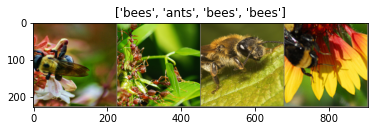

In [ ]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

## 訓練に関する処理
- モデルの訓練はCNNの回で学んだ処理とほぼ同じである．
- 関数化してしまおう．

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

## 予測結果の可視化

In [ ]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

## モデルのロードと訓練
- 今回，torchvisionパッケージが有する標準的なモデルを流用し，転移学習することを考える．
- resnet18をpretrained=Trueとすることで，ImageNetで事前訓練済みのresnet18をロードすることができる．


In [ ]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# 事前訓練では1000クラス分類になっているため，出力層（model_ft.fc）を付け替える．
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

## Fine-tuning
- 以下のセルでモデルの訓練ができる．
- 今回は，EncoderもClassifierも両方とも訓練するためFine-tuningになる．

In [ ]:
# 訓練開始
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 0.6699 Acc: 0.6434
val Loss: 0.3072 Acc: 0.8758

Epoch 1/24
----------
train Loss: 0.4463 Acc: 0.8115
val Loss: 0.2338 Acc: 0.9150

Epoch 2/24
----------
train Loss: 0.5783 Acc: 0.7377
val Loss: 0.3289 Acc: 0.8889

Epoch 3/24
----------
train Loss: 0.3492 Acc: 0.8361
val Loss: 0.3833 Acc: 0.8562

Epoch 4/24
----------
train Loss: 0.3135 Acc: 0.8484
val Loss: 0.2256 Acc: 0.9150

Epoch 5/24
----------
train Loss: 0.5516 Acc: 0.7869
val Loss: 0.4307 Acc: 0.8693

Epoch 6/24
----------
train Loss: 0.3501 Acc: 0.8730
val Loss: 0.4443 Acc: 0.8431

Epoch 7/24
----------
train Loss: 0.3795 Acc: 0.8443
val Loss: 0.3185 Acc: 0.9085

Epoch 8/24
----------
train Loss: 0.3732 Acc: 0.8730
val Loss: 0.2646 Acc: 0.9150

Epoch 9/24
----------
train Loss: 0.3416 Acc: 0.8402
val Loss: 0.2573 Acc: 0.9281

Epoch 10/24
----------
train Loss: 0.2728 Acc: 0.8934
val Loss: 0.2730 Acc: 0.9281

Epoch 11/24
----------
train Loss: 0.3354 Acc: 0.8607
val Loss: 0.3054 Acc: 0.9216

Ep

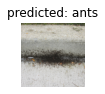

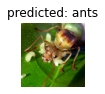

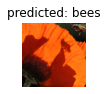

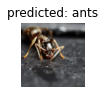

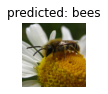

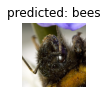

In [ ]:
visualize_model(model_ft)

```
Epoch 24/24
----------
train Loss: 0.2402 Acc: 0.9098
val Loss: 0.2910 Acc: 0.9150

Training complete in 2m 37s
Best val Acc: 0.934641
```
ということで，最終到達精度は訓練90.98%，検証91.50%となった．最高到達精度は検証93.46%らしい．ファインチューニングによって120枚＊2の画像を25エポック訓練するだけで，見分けるのが難しそうな2値分類を比較的高精度に実装できた．

## スクラッチ学習
- 続いて，転移学習せずに（pretrained=False）訓練して比較してみよう．

In [ ]:
model_sc = models.resnet18(pretrained=False)
num_ftrs = model_sc.fc.in_features
# 事前訓練では1000クラス分類になっているため，出力層（model_ft.fc）を付け替える．
model_sc.fc = nn.Linear(num_ftrs, 2)

model_sc = model_sc.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_sc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

# 訓練開始
model_sc = train_model(model_sc, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 0.7502 Acc: 0.4877
val Loss: 0.7098 Acc: 0.6340

Epoch 1/24
----------
train Loss: 0.6907 Acc: 0.6189
val Loss: 0.5768 Acc: 0.7059

Epoch 2/24
----------
train Loss: 0.8875 Acc: 0.5820
val Loss: 1.6415 Acc: 0.5556

Epoch 3/24
----------
train Loss: 0.8986 Acc: 0.5861
val Loss: 0.9880 Acc: 0.4771

Epoch 4/24
----------
train Loss: 0.7387 Acc: 0.6066
val Loss: 0.9527 Acc: 0.5621

Epoch 5/24
----------
train Loss: 0.6730 Acc: 0.6352
val Loss: 0.6426 Acc: 0.6863

Epoch 6/24
----------
train Loss: 0.6718 Acc: 0.6270
val Loss: 0.6702 Acc: 0.6863

Epoch 7/24
----------
train Loss: 0.6008 Acc: 0.6885
val Loss: 0.6338 Acc: 0.6732

Epoch 8/24
----------
train Loss: 0.5571 Acc: 0.7049
val Loss: 0.6186 Acc: 0.6928

Epoch 9/24
----------
train Loss: 0.6139 Acc: 0.7049
val Loss: 0.6465 Acc: 0.7059

Epoch 10/24
----------
train Loss: 0.5679 Acc: 0.7213
val Loss: 0.6043 Acc: 0.7059

Epoch 11/24
----------
train Loss: 0.6146 Acc: 0.6885
val Loss: 0.5944 Acc: 0.6993

Ep

```
Epoch 24/24
----------
train Loss: 0.5615 Acc: 0.7008
val Loss: 0.5800 Acc: 0.7190

Training complete in 2m 34s
Best val Acc: 0.718954
```
ということで，スクラッチ学習では25エポックではせいぜい70%程度の精度となった．

## 転移学習（エンコーダの凍結）
- 最後に，転移学習（エンコーダのパラメータは凍結して訓練）を行なってみよう．

In [ ]:
model_conv = torchvision.models.resnet18(pretrained=True)
# model_convのパラメータはgradを用いない（＝パラメータを更新しない）
for param in model_conv.parameters():
    param.requires_grad = False

# 出力層のみ入れ替えた上で，ここはパラメータを更新する．
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Optimizerには出力層fcのパラメータのみを渡す．
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

# 訓練開始
model_conv = train_model(model_conv, criterion, optimizer_conv, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 0.6223 Acc: 0.6885
val Loss: 0.2360 Acc: 0.9281

Epoch 1/24
----------
train Loss: 0.6314 Acc: 0.7213
val Loss: 0.2245 Acc: 0.9020

Epoch 2/24
----------
train Loss: 0.3904 Acc: 0.8484
val Loss: 0.2428 Acc: 0.8824

Epoch 3/24
----------
train Loss: 0.4016 Acc: 0.8156
val Loss: 0.4787 Acc: 0.8170

Epoch 4/24
----------
train Loss: 0.6603 Acc: 0.7295
val Loss: 0.3783 Acc: 0.8562

Epoch 5/24
----------
train Loss: 0.4875 Acc: 0.8320
val Loss: 0.2113 Acc: 0.9346

Epoch 6/24
----------
train Loss: 0.4817 Acc: 0.8197
val Loss: 0.2477 Acc: 0.9020

Epoch 7/24
----------
train Loss: 0.3056 Acc: 0.8648
val Loss: 0.1709 Acc: 0.9346

Epoch 8/24
----------
train Loss: 0.4115 Acc: 0.8156
val Loss: 0.1787 Acc: 0.9150

Epoch 9/24
----------
train Loss: 0.3529 Acc: 0.8525
val Loss: 0.1583 Acc: 0.9346

Epoch 10/24
----------
train Loss: 0.3695 Acc: 0.8402
val Loss: 0.1726 Acc: 0.9412

Epoch 11/24
----------
train Loss: 0.3366 Acc: 0.8689
val Loss: 0.2016 Acc: 0.9216

Ep

```
Epoch 24/24
----------
train Loss: 0.2578 Acc: 0.8934
val Loss: 0.1634 Acc: 0.9346

Training complete in 2m 16s
Best val Acc: 0.947712
```
ということで，転移学習（Encoder凍結）では25エポックで94.77%と最高精度を達成した．Fine-tuningの方が全体を再訓練する分良くなるように思えたが93.46%となっている．これは，小規模データセットでEncoderを追加訓練することにより，特徴表現がターゲットドメインの訓練データに過学習してしまっている可能性があるからである．したがって，ターゲットドメインの追加データが小規模な場合は，Encoderを凍結するほうが高速に訓練ができかつ，精度が安定することがある（ただし，Encoderがすでにアリとハチの分類に関する特徴表現を獲得できているからこの結果になっていると考えられ，全く未知のクラスが分類できるとは限らない）．

## 練習問題
- 実施するのは余力のある人だけで構わない．
- 各自好きな画像を適当に用意しよう．
- 以下のようにpretrainedモデルをロードすることで1000クラスの一般物体認識モデルをそのまま流用できる．
- 各自用意した画像を以下のmodelに入力し，予測結果がどうなるのかを確認してみよう．

In [ ]:
model = models.resnet18(pretrained=True)
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
# 1000クラスのクラス名を取得する
import json
from pathlib import Path
from torchvision.datasets.utils import download_url

def get_classes():
    if not Path("data/imagenet_class_index.json").exists():
        # ファイルが存在しない場合はダウンロードする。
        download_url("https://git.io/JebAs", "data", "imagenet_class_index.json")

    # クラス一覧を読み込む。
    with open("data/imagenet_class_index.json",encoding="utf-8") as f:
        data = json.load(f)
        class_names = [x["ja"] for x in data]

    return class_names

class_names = get_classes()
class_names

['テンチ',
 '金魚',
 'ホホジロザメ',
 'イタチザメ',
 'ハンマーヘッド',
 'シビレエイ',
 'アカエイ',
 'コック',
 'めんどり',
 'ダチョウ',
 'アトリ',
 'ゴシキヒワ',
 'ハウスフィンチ',
 'ユキヒメドリ',
 'インディゴホオジロ',
 'ロビン',
 'ブルブル',
 'カケス',
 'カササギ',
 '四十雀',
 '水クロウタドリ',
 '凧',
 '白頭ワシ',
 'ハゲワシ',
 'カラフトフクロウ',
 '欧州ファイアサラマンダー',
 '共通イモリ',
 'イモリ',
 'サンショウウオを発見',
 'アホロートル',
 'ウシガエル',
 'アマガエル',
 'つかれたカエル',
 'とんちき',
 'オサガメ',
 '鼈',
 'テラピン',
 'ハコガメ',
 '縞模様のヤモリ',
 '共通イグアナ',
 'アメリカンカメレオン',
 'ウィッペイル',
 'アガマトカゲ',
 'フリルトカゲ',
 'アリゲータートカゲ',
 'アメリカドクトカゲ',
 '緑のトカゲ',
 'アフリカのカメレオン',
 'コモドドラゴン',
 'アフリカのワニ',
 'アメリカワニ',
 'トリケラトプス',
 '雷のヘビ',
 'リングネックスネーク',
 'ホーノースヘビ',
 '緑のヘビ',
 'キングスネーク',
 'ガータースネーク',
 '水蛇',
 'つるヘビ',
 '夜のヘビ',
 'ボア・コンストリクター',
 'ロックパイソン',
 'インドコブラ',
 'グリーンマンバ',
 'ウミヘビ',
 'ツノクサリヘビ',
 'ダイヤ',
 'サイドワインダー',
 '三葉虫',
 '刈り入れ作業者',
 'サソリ',
 '黒と金の庭クモ',
 '納屋クモ',
 '庭クモ',
 'クロゴケグモ',
 'タランチュラ',
 'オオカミのクモ',
 'ダニ',
 '百足',
 'クロライチョウ',
 '雷鳥',
 'ひだえりの付いたライチョウ',
 '草原チキン',
 '孔雀',
 'ウズラ',
 'ヤマウズラ',
 'アフリカの灰色',
 'コンゴウインコ',
 '硫黄トキオウム',
 'インコ',
 'バンケン',
 '蜂食べる人',
 'サイチョウ',
 'ハチドリ',
 '錐嘴',
 